In [8]:
import os
import cv2
import json
import numpy as np
from pathlib import Path
from random import randint
import matplotlib.pyplot as plt

In [9]:
class_files_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\labels")
json_root_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations")
output_path = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\annotations_classes")
image_root_path = Path("C:\\Users\\AMET\\DocGaid\\diploma\\data\\full_teeth\\images")

In [10]:
json_file_paths = list(json_root_path.glob("*.json"))

In [11]:
tooth_classes = {0: '11', 1: '12', 2: '13', 3: '14',4: '15', 5: '16', 6: '17', 7: '18', 8: '21', 9: '22', 10: '23', 11: '24', 12: '25', 13: '26', 14: '27', 15: '28', 16: '31', 17: '32', 18: '33', 19: '34', 20: '35', 21: '36', 22: '37', 23: '38', 24: '41', 25: '42', 26: '43', 27: '44', 28: '45', 29: '46', 30: '47', 31: '48'}
    

In [12]:
def normalize_bounding_boxes(json_data):
    image_width = json_data['image']['width']
    image_height = json_data['image']['height']

    for annotation in json_data['annotations']:
        bbox = annotation['bounding_box']
        bbox['h'] /= image_height
        bbox['w'] /= image_width
        bbox['x'] /= image_width
        bbox['y'] /= image_height

    return json_data

def get_class_file_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    bboxes = []
    classes = []
    for line in lines:
        elements = line.split()
        class_id = int(elements[0])
        classes.append(class_id)
        bbox = [float(e) for e in elements[1:]]
        bboxes.append(bbox)
    return np.array(classes), np.array(bboxes)


def get_json_file_data(json_file_path:os.PathLike):
    with open(json_file_path, 'r') as file:
        json_data = json.load(file)
    
    return json_data

def segment_json_to_numpy(json_file_path:os.PathLike, get_image_shape:bool=True):
    json_data = get_json_file_data(json_file_path)
    bboxes = []
    for segment in json_data['annotations']:
        box = segment['bounding_box']
        bboxes.append([box['x'], box['y'], box['w'], box['h']])
    
    if get_image_shape:
        return np.array(bboxes), (json_data['image']['height'], json_data['image']['width'])

def xywh2xyxy(boxes:np.ndarray):
    # assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    # boxes[:, 0] -= boxes[:, 2]/2
    # boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes

def xcycwh2xyxy(boxes:np.ndarray):
    assert boxes.ndim==2 and boxes.shape[1]==4, "The boxes should be of shape n * 4"
    
    boxes[:, 0] -= boxes[:, 2]/2
    boxes[:, 1] -= boxes[:, 3]/2
    boxes[:, 2] += boxes[:, 0]
    boxes[:, 3] += boxes[:, 1]
    
    return boxes    
def normalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] /= width
    xyxy_boxes[:, 2] /= width
    xyxy_boxes[:, 1] /= height
    xyxy_boxes[:, 3] /= height
    
    return xyxy_boxes


def denormalize_boxes(xyxy_boxes:np.ndarray, image_shape:tuple[int,int]):
    height, width = image_shape
    xyxy_boxes[:, 0] *= width
    xyxy_boxes[:, 2] *= width
    xyxy_boxes[:, 1] *= height
    xyxy_boxes[:, 3] *= height
    
    return xyxy_boxes.astype(int)
  
def rectangles_on_image(image:np.ndarray,
                        boxes:np.ndarray,
                        classes:list = None,
                        box_color:tuple=(255, 0, 0),
                        label_color:tuple=(0, 0, 0),
                        
                        thickness:int=6):
    for box in boxes:
        x1,y1,x2,y2 = box
        cv2.rectangle(image, (x1,y1), (x2,y2), box_color, thickness)
    
    if classes is not None:
        for i, tooth_class in enumerate(classes):
            cv2.putText(image, str(tooth_class), (boxes[i][:2]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.8, label_color, 10)
        
    return image


def get_closest_box_index(box:np.ndarray, target_boxes:np.ndarray):
    # Aoverlap=(max(l0,l1)−min(r0,r1))⋅(max(t0,t1)−min(b0,b1)).
    # x_overlap = Math.max(0, Math.min(rect1.right, rect2.right) - Math.max(rect1.left, rect2.left));
    # y_overlap = Math.max(0, Math.min(rect1.bottom, rect2.bottom) - Math.max(rect1.top, rect2.top));
    # overlapArea = x_overlap * y_overlap;
    overlap_areas = []
    # rect1.left = box[0] rext1.top = box[1]
    # rect2.left = target_box[0] rext2.top = target_box[1]
    # rect1.right = box[2] rext1.bottom = box[3]
    # rect2.right = target_box[2] rext2.bottom = target_box[3]
    
    for target_box in target_boxes:
        x_overlap = max(0, min(box[2],target_box[2] ) - max(box[0], target_box[0]))
        y_overlap = max(0, min(box[3], target_box[3]) - max(box[1], target_box[1]))
        overlap_areas.append(x_overlap*y_overlap)
    
    closest_box_index = np.argmax(overlap_areas)
    
    return closest_box_index
    
def get_box_matching_mask(target_boxes, boxes_to_match):
    # assert abs(boxes_to_match.shape[0]-target_boxes.shape[0])==0, "The number of target and matching boxes should be the same"
    mask = []
    for box_to_match in boxes_to_match:
        closest_box_index = get_closest_box_index(box_to_match, target_boxes)
        mask.append(closest_box_index)
        
    return mask

def get_segmentation_polygon(json_file_path:os.PathLike):
    segment = []
    json_data = get_json_file_data(json_file_path)
    for tooth_data in json_data['annotations']:
        path = tooth_data['polygon']['path']
        segment.append([[point['x'], point['y']] for point in path])
    
    return segment

def normalize_segmentations(json_file_path, segmentation:np.array):
    json_data = get_json_file_data(json_file_path)
    height = json_data['image']['height']
    width = json_data['image']['width']
    divisor = np.array([width, height])  # Replace num1 and num2 with your actual numbers

    normalized_segmentation = segmentation / divisor
    return normalized_segmentation

def denormalize_segmentation(json_file_path, normalized_segmentation:np.array):
    json_data = get_json_file_data(json_file_path)
    height = json_data['image']['height']
    width = json_data['image']['width']
    multiplier = np.array([width, height])

    denormalized_segmentation = normalized_segmentation * multiplier
    return denormalized_segmentation

def tooth_class_convert(segmentation_classes:np.array, tooth_classes:dict):
    result = np.empty_like(segmentation_classes)
    for i in range(len(segmentation_classes)):
        result[i] = tooth_classes[segmentation_classes[i]]
    
    return result

In [ ]:
for json_file_path in json_file_paths:
    if not json_file_path.exists():
        continue
    
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    print(class_file_path.stem)
    if not class_file_path.exists():
        continue
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")

    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)
    if target_boxes.size == 0:
        continue 
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)
    target_boxes = xcycwh2xyxy(target_boxes)
    
    box_matching_mask = get_box_matching_mask(segmentation_boxes, target_boxes)

    segmentation_boxes = segmentation_boxes[box_matching_mask]
    segmentation_classes = target_classes
    segmentation_classes = tooth_class_convert(segmentation_classes, tooth_classes)
    
    segmentation = get_segmentation_polygon(json_file_path)
    
    image = cv2.imread(str(image_path))

    layer = np.zeros_like(image)

    alpha = 0.5  
    
    for segment in segmentation:
        ctr = np.array(segment, dtype=np.int32)
        color = (randint(0, 255), randint(0, 255), randint(0, 255))

        cv2.fillPoly(layer, [ctr], color=color)

        fake_image = cv2.addWeighted(image, alpha, layer, 1-alpha, 0)

    fig = plt.figure(figsize=(fake_image.shape[1]/80, fake_image.shape[0]/80), dpi=80)  # adjust the figure size based on the original image size
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)
    # print(segmentation_classes)
    # ax.imshow(rectangles_on_image(fake_image.copy(), denormalize_boxes(segmentation_boxes, img_shape), segmentation_classes,label_color=(255,255,0), thickness=8))
    # plt.savefig(f'{class_file_path.stem}.png', format='png', dpi=80)  # save the figure to a file
    # plt.show()


In [14]:
from natsort import natsorted
json_file_paths = natsorted(json_file_paths)

1


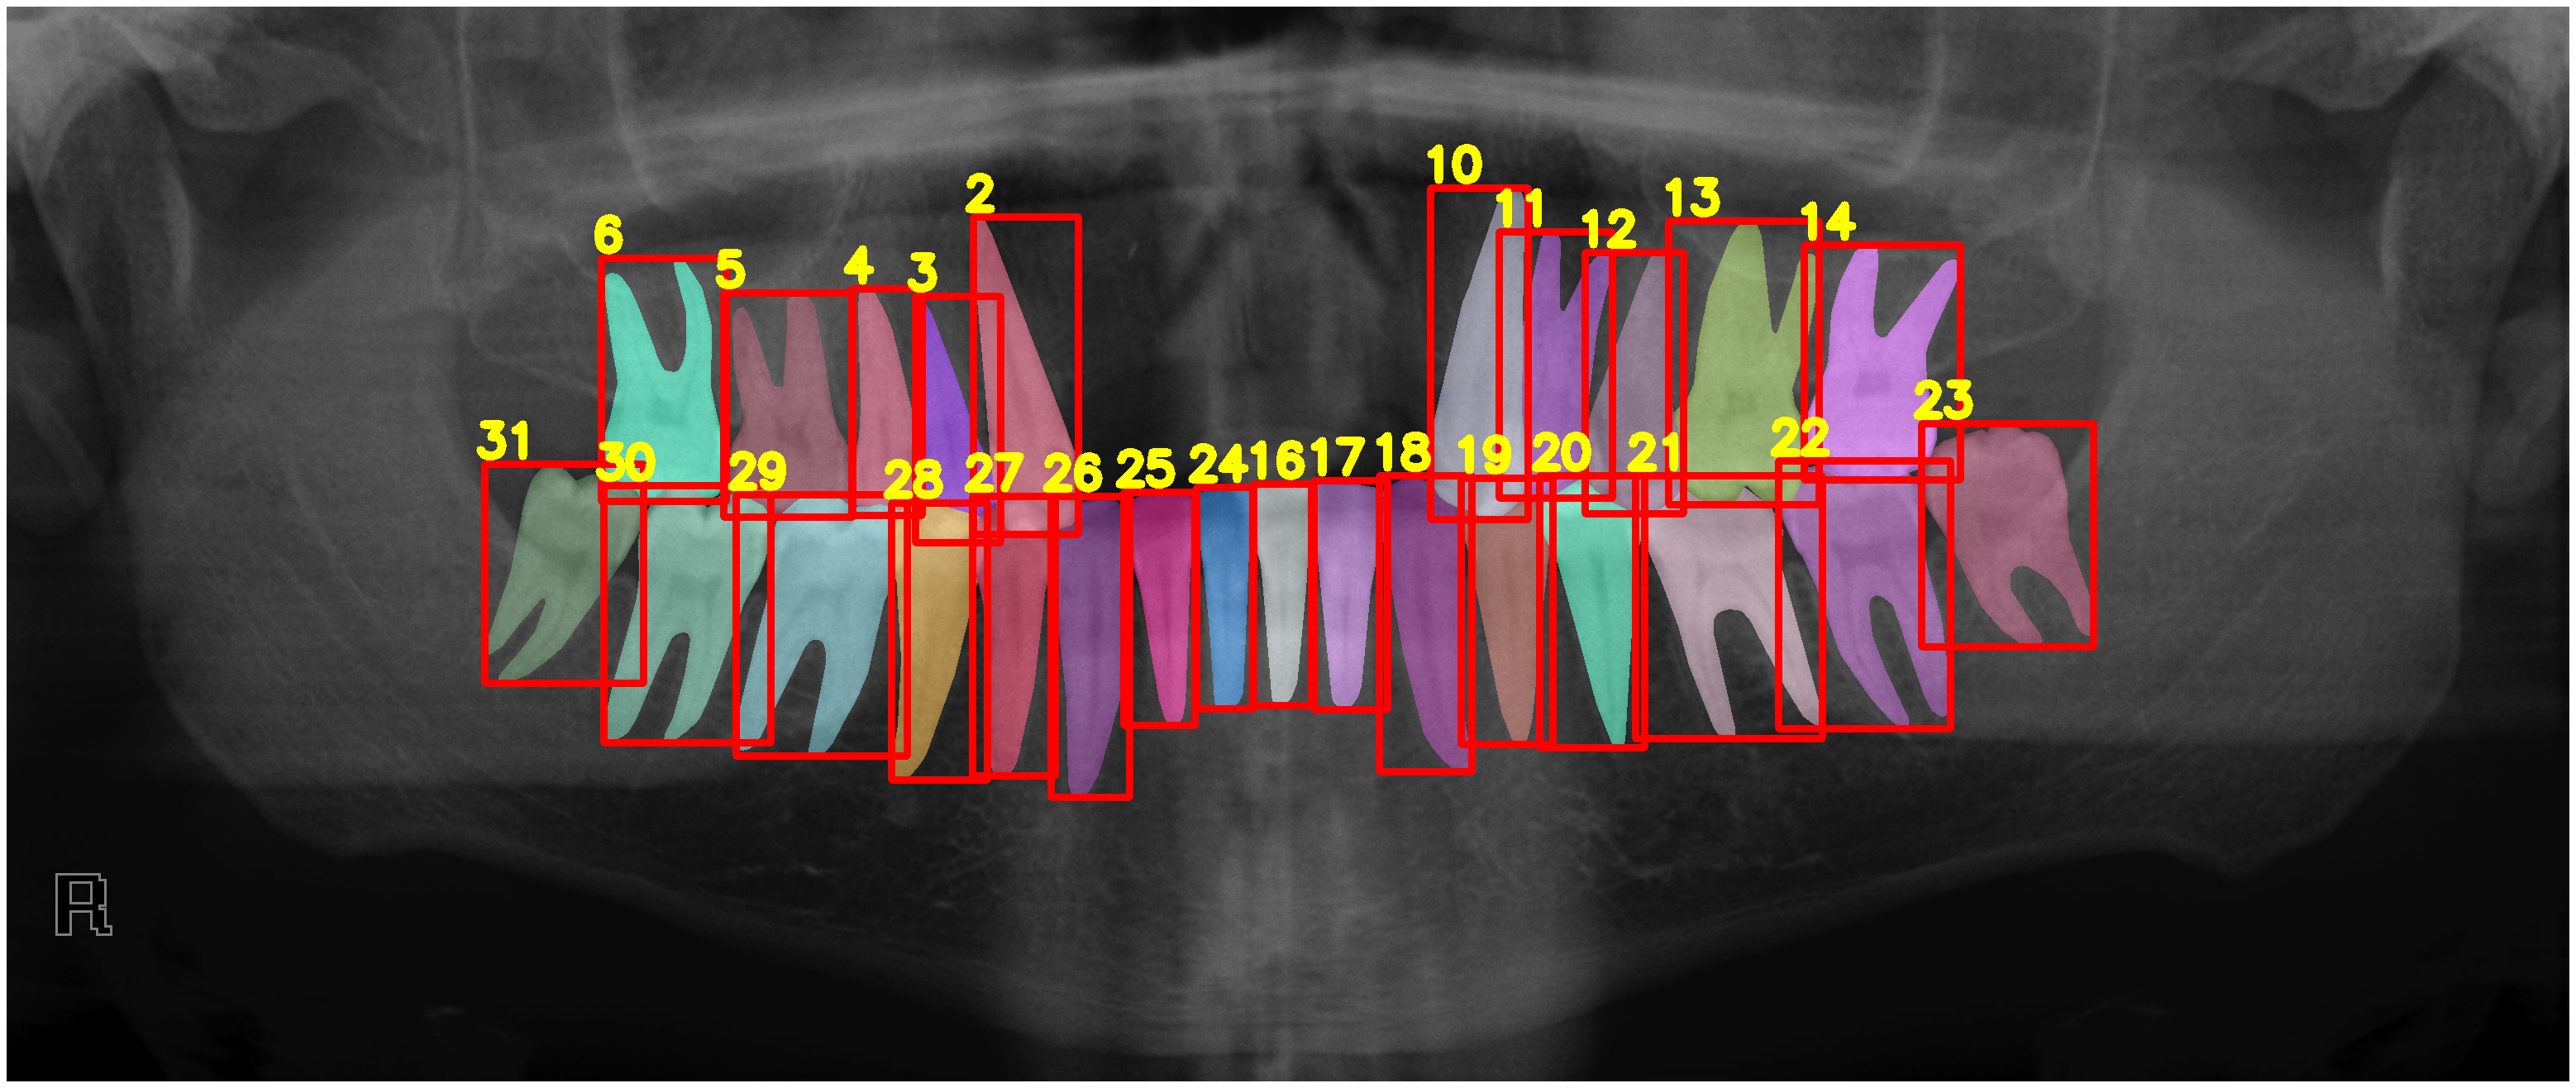

In [17]:
def flatten_nested_list(nested_list):
    return [coordinate for sublist in nested_list for coordinate in sublist]

def normalize_segmentations(polygon, img_shape):
    polygon = np.array(polygon)
    polygon[::2] /= img_shape[1]
    polygon[1::2] /= img_shape[0]
    polygon = np.clip(polygon, 0, 1)
  
    return polygon

def write_txt_file(txt_file_path, class_id, polygon):
    
    with open(txt_file_path, 'a') as file:
        file.write(f'{class_id}')
        for point in polygon:
            file.write(f" {point}")
        file.write('\n')
        
def extract_elements(l2, l1):
    return [l2[i] for i in l1]

prediction_labels = Path("C:\\Users\\AMET\\DocGaid\\yolov8\\data\\new_single_tooth\\prediction_labels") 

for json_file_path in json_file_paths:
    if not json_file_path.exists():
        continue
    destination_label_path = (prediction_labels/json_file_path.stem).with_suffix(".txt")
    
    class_file_path = (class_files_root_path/json_file_path.stem).with_suffix(".txt")
    print(class_file_path.stem)
    if not class_file_path.exists():
        continue
    image_path = (image_root_path/json_file_path.stem).with_suffix(".jpg")

    segmentation_boxes, img_shape = segment_json_to_numpy(json_file_path)
    target_classes, target_boxes = get_class_file_data(class_file_path)
    if target_boxes.size == 0:
        continue 
    segmentation_boxes = normalize_boxes(xywh2xyxy(segmentation_boxes), img_shape)
    target_boxes = xcycwh2xyxy(target_boxes)
    
    box_matching_mask = get_box_matching_mask(segmentation_boxes, target_boxes)

    segmentation_boxes = segmentation_boxes[box_matching_mask]
    segmentation_classes = target_classes
    # segmentation_classes = tooth_class_convert(segmentation_classes, tooth_classes)
    
    segmentation = get_segmentation_polygon(json_file_path)
    segmentation = extract_elements(segmentation, box_matching_mask)
    
    # print(box_matching_mask)
    # print(segmentation)
    # break
    image = cv2.imread(str(image_path))

    layer = np.zeros_like(image)

    alpha = 0.5  
    
    for i, segment in enumerate(segmentation):
        flatten_segment = flatten_nested_list(segment)
        normalized_segmentations = normalize_segmentations(flatten_segment, img_shape)
        # print(target_classes[i])
        # write_txt_file(destination_label_path, target_classes[i], normalized_segmentations)
        # break
        ctr = np.array(segment, dtype=np.int32)
        color = (randint(0, 255), randint(0, 255), randint(0, 255))

        cv2.fillPoly(layer, [ctr], color=color)

        fake_image = cv2.addWeighted(image, alpha, layer, 1-alpha, 0)

    fig = plt.figure(figsize=(fake_image.shape[1]/80, fake_image.shape[0]/80), dpi=80)  # adjust the figure size based on the original image size
    ax = plt.Axes(fig, [0., 0., 1., 1.], )
    ax.set_axis_off()
    fig.add_axes(ax)


    ax.imshow(rectangles_on_image(fake_image.copy(), denormalize_boxes(segmentation_boxes, img_shape), segmentation_classes,label_color=(255,255,0), thickness=8))
    # plt.savefig(f'{class_file_path.stem}.png', format='png', dpi=80)  # save the figure to a file
    plt.show()
    break

In [16]:
import os
import img2pdf

# specify the directory
folder = r"C:\Users\AMET\DocGaid\yolov8\results"

# get all image files from the directory
images = [i for i in os.listdir(folder) if i.endswith(".jpg") or i.endswith(".png")]

# sort the images by name
images.sort()

# convert each image to pdf
pdf_bytes = img2pdf.convert([os.path.join(folder, i) for i in images])

# write the pdf bytes to a file
with open("tooth_segmentation.pdf", "wb") as f:
    f.write(pdf_bytes)


Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an a